# Calculating Customer Lifetime Value (CLV)

## 1. Introduction

What we're going to do here is to calculate the "Customer Lifetime Value".

There are two ways this can be interpreted:
1. The value of a customer **up until today**  
   This is covered by the Aggregated and the Segmented approach
2. The value of a customer **up until some time in the future**  
   Also called **predictive Lifetime Value (pLTV)**
   This is covered by the Predictive approach

### 1.1. Sources

- [Definitive guide to pCLV](https://www.analyticsvidhya.com/blog/2020/10/a-definitive-guide-for-predicting-customer-lifetime-value-clv/)  
- [BTYD](https://towardsdatascience.com/predicting-customer-lifetime-value-with-buy-til-you-die-probabilistic-models-in-python-f5cac78758d9)  
- [Online Retail Dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/00352/)

## 2. Import libraries

In [29]:
pip install lifetimes

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lifetimes
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix

## 3. Read data from CSV

In [31]:
df = pd.read_csv('online_retail.csv', parse_dates=['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 4. Preparing the data

In [32]:
# Only keep the columns we actually need
df = df[['InvoiceNo', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID']]

In [33]:
# Removing null CustomerIDs
df = df[pd.notnull(df['CustomerID'])]

In [34]:
# Calculating total sales
df['TotalSales'] = df['Quantity'].multiply(df['UnitPrice'])

In [35]:
# Remove negative transactions (returns)
df = df[df['TotalSales'] > 0]

In [36]:
# Show the result
df.head()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalSales
0,536365,6,2010-12-01 08:26:00,2.55,17850.0,15.30
1,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34
2,536365,8,2010-12-01 08:26:00,2.75,17850.0,22.00
3,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34
4,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34


## 4. Aggregated CLV

This uses the collective data from all customers to come up with a single **average Customer Lifetime Value shared by all customers** .  
Assigning every customer the same value sounds **not very accurate** as it ignores different types of customers but it's a good exercise to understand the concept.  
Both the Aggregated CLV and the Segmented CLV use a **deterministic approach** to get the actual Customer Lifetime Value up until the end of the given timeframe.

This method gives us the CLV up until today (but not at a future time).  
It is calculated using this simple formula:

`CLV = ((Average Sales * Purchase Frequency) / Churn Rate)`

Where:  
- Average Sales = Total Sales / Total Number of Orders
- Purchase Frequency = Total Number of Orders / Total unique Customers
- Retention Rate = Total Number of Customers with > 1 Orders / Total unique Customers
- Curn Rate = 1 - Retention Rate

### 4.1. Aggregate customer data

In [37]:
# Count purchases and add up sales
clv_agg = df.groupby('CustomerID').agg({'InvoiceNo': lambda x: len(x),
                                        'TotalSales': lambda x: sum(x)}).reset_index()

# Rename columns
clv_agg.columns = ['CustomerID', 'Frequency', 'TotalSales']

# Show results
clv_agg.head()

,CustomerID,Frequency,TotalSales
0,12346.0,1,77183.60
1,12347.0,182,4310.00
2,12348.0,31,1797.24
3,12349.0,73,1757.55
4,12350.0,17,334.40


### 4.2. Calculate intermediate metrics

In [38]:
# Calculate Average Sales
avg_sales = round(np.mean(clv_agg['TotalSales']),2)

# Calculate Purchase Frequency
purchase_freq = round(np.mean(clv_agg['Frequency']), 2)

# Calculate Churn Rate
retention_rate = clv_agg[clv_agg['Frequency'] > 1].shape[0] / clv_agg.shape[0]
churn = round(1 - retention_rate, 2)

### 4.3. Calculate CLV

In [39]:
# Applying the CLV formula
clv = round((avg_sales * purchase_freq / churn), 2)

In [40]:
# Show the result
print(clv)

9420882.22


So the average CLV for this dataset is 9,420,882.22.  
Note that this is gross revenue, not actual profit.

## 5. Segmented CLV

Calculating CLV on customer segments already makes more sense than an overall CLV.  
Basically how this works is you build your segments (i.e. by using Recency, Frequency, Monetary (RFM) values) and then do the exact same as with the Aggregated CLV but instead of grouping by 'CustomerID' you would group by RFM-Segment or Segments-Bucket.

## 6. Predictive CLV

This uses a **probabilistic** Machine Learning model to use historic data to **predict a Customer Lifetime Value** for some time in the future.

To do that we're going to make use of the **Buy Till You Die (BTYD)** class of statistical models.  
BTYD is an umbrella term for statistical models to predict the customer lifetime value based on non-contractual continuous transactions.  

In particular we're going to use the [Beta Geometric/Negative Binomial Distribution model (BG/NBD)](http://www.brucehardie.com/papers/bgnbd_2004-04-20.pdf) to predict future transactions and churn in combination with a **Gamma-Gamma Model** to predict future order values.

In [41]:
# Create the summary data using summary_data_from_transaction_data function
summary = lifetimes.utils.summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', 'TotalSales', freq='D')
summary = summary.reset_index()
summary.head()

,CustomerID,frequency,recency,T,monetary_value
0,12346.0,0.0,0.0,325.0,0.000000
1,12347.0,6.0,365.0,367.0,599.701667
2,12348.0,3.0,283.0,358.0,301.480000
3,12349.0,0.0,0.0,18.0,0.000000
4,12350.0,0.0,0.0,310.0,0.000000


The lifetimes library provides us with the function [summary_data_from_transaction_data](https://lifetimes.readthedocs.io/en/latest/lifetimes.html#lifetimes.utils.summary_data_from_transaction_data) which calculates a couple of [metrics](https://lifetimes.readthedocs.io/en/latest/Quickstart.html#the-shape-of-your-data) for each user:

1. **frequency**<br>
   The number of *repeat* purchases the customer has made.<br>
   This means that it’s one less than the total number of purchases.<br>
   So a frequency of 1 actually represents 2 orders and one-time buyers have a frequency of 0
2. **recency**<br>
   The age of the customer when they made their most recent purchases.<br>
   This is equal to the duration between a customer’s first purchase and their latest purchase.<br>
   Thus if they have made only 1 purchase, the recency is 0.
3. **T**<br>
   The duration between the customer's first purchase and the end of the timeframe.
4. **monetary_value**<br>
   The average value of the customer's purchases.<br>
   This is equal to the sum of all of the customer's purchases divided by the total number of their purchases.<br>
   Note that per default this disregards the first transaction of each order (as is needed for subsequent calculations)<br>
   So `monetary_value = sum(all purchases except first) / (number of purchases - 1)`

In [42]:
# Fitting the BG/NBD model
bgf = lifetimes.BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 4338 subjects, a: 0.00, alpha: 68.91, b: 6.75, r: 0.83>

### 6.1. Estimate Customer's probability to be 'alive'

This is done using a combination of the Frequency and Recency metrics.

So a customer has a high probability of being 'alive' if they purchase frequently and recently.

In [43]:
# Compute the customer alive probability
summary['p_alive'] = bgf.conditional_probability_alive(summary['frequency'], summary['recency'], summary['T'])

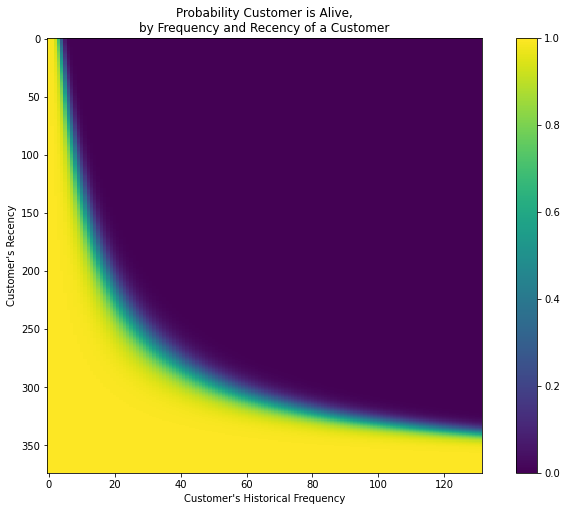

In [44]:
plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

The graph shows that the probability for a customer to be 'alive' is greatest under the following conditions:
- Few purchases (low frequency) in a very short amount of time (low recency) -> Upper left corner
- Few purchases (low frequency) but also very recently (high recency) -> Bottom left corner
- Many purchases (high frequency) and also recently (high recency) -> Bottom right corner

The probability of being 'alive' is very low, if:
- A lot of purchases (high frequency) but some time ago (low recency) -> Upper right corner

### 6.2. Predict future number of transactions

In [45]:
# Set timeframe (30 days)
t = 30

summary['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T']), 2)

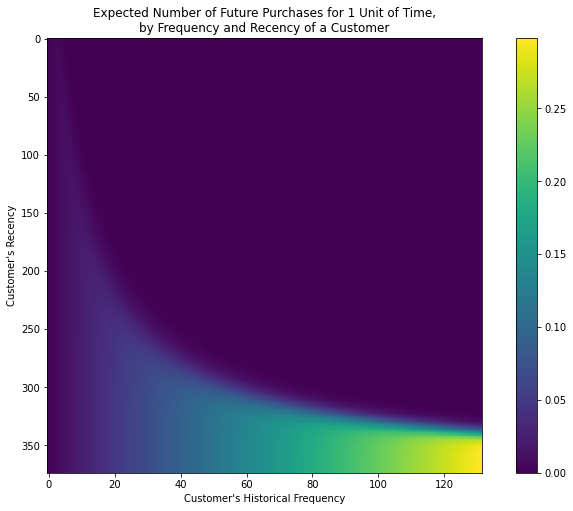

In [46]:
plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

The graph shows that the number of expected future purchases increases for customers with high frequency and high recency.

### 6.3. Predict CLV

Given predicted future transactions and the probability of being alive we can now use the Gamma-Gamma Model to predict the Customer Lifetime Value.

To do that we only include customers who made repeat purchases (frequency > 0) as one-time buyers are considered already dead.

In [47]:
return_customers_summary = summary[summary['frequency'] > 0]

To get an idea of how many of our customers are actually one-time buyers let's take a look at the frequency distribution

Percentage of one-time buyers: 35.68%


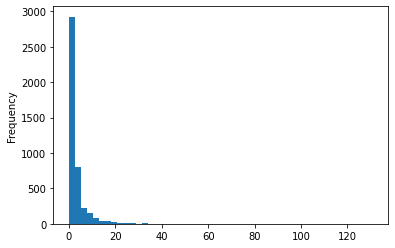

In [48]:
summary['frequency'].plot(kind='hist', bins=50)
one_time_buyers = round(sum(summary['frequency'] == 0) / float(len(summary)) * (100), 2)
print('Percentage of one-time buyers: {}%'.format(one_time_buyers))

In [49]:
# Modeling the monetary value using Gamma-Gamma Model
ggf = lifetimes.GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(return_customers_summary['frequency'],
       return_customers_summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 11.13, q: 0.84, v: 11.29>

In [50]:
# Calculating the conditional expected average profit for each customer per transaction
summary = summary[summary['monetary_value'] > 0]
summary['exp_avg_sales'] = ggf.conditional_expected_average_profit(summary['frequency'],
                                       summary['monetary_value'])

In [51]:
# Predicting Customer Lifetime Value for the next 30 days
summary['predicted_clv'] = ggf.customer_lifetime_value(bgf,
                                                       summary['frequency'],
                                                       summary['recency'],
                                                       summary['T'],
                                                       summary['monetary_value'],
                                                       time=1, # lifetime in months
                                                       freq='D', # frequency in which the data is present (T)      
                                                       discount_rate=0.01) # discount rate

In [52]:
summary.head()

,CustomerID,frequency,recency,T,monetary_value,p_alive,pred_num_txn,exp_avg_sales,predicted_clv
1,12347.0,6.0,365.0,367.0,599.701667,0.999698,0.47,603.040247,280.409518
2,12348.0,3.0,283.0,358.0,301.480000,0.999177,0.27,306.725889,81.591026
5,12352.0,6.0,260.0,296.0,368.256667,0.999406,0.56,371.034926,206.034640
9,12356.0,2.0,303.0,325.0,269.905000,0.999478,0.22,277.562534,59.125290
11,12358.0,1.0,149.0,150.0,683.200000,0.999486,0.25,704.704679,174.550478


#### 6.3.1. Manually calculate pCLV

You may also manually calculate the CLV by multiplying the predicted number of transactions with the expected average sales.  
It might not be as accurate but can be used for validation.

In [53]:
# Manually calculate CLV
summary['manual_predicted_clv'] = summary['pred_num_txn'] * summary['exp_avg_sales']
summary.head()

,CustomerID,frequency,recency,T,monetary_value,p_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv
1,12347.0,6.0,365.0,367.0,599.701667,0.999698,0.47,603.040247,280.409518,283.428916
2,12348.0,3.0,283.0,358.0,301.480000,0.999177,0.27,306.725889,81.591026,82.815990
5,12352.0,6.0,260.0,296.0,368.256667,0.999406,0.56,371.034926,206.034640,207.779558
9,12356.0,2.0,303.0,325.0,269.905000,0.999478,0.22,277.562534,59.125290,61.063757
11,12358.0,1.0,149.0,150.0,683.200000,0.999486,0.25,704.704679,174.550478,176.176170
